In [1]:
import numpy as np
from qiskit_mps_initializer.datatypes import QuantumState

# Example: use 3 qubits => vectors of length 8
psi = np.array([1, 2, 3, 4, 5, 6, 7, 8], dtype=complex)
phi = np.array([8, 7, 6, 5, 4, 3, 2, 1], dtype=complex)

# Normalize
psi = psi / np.linalg.norm(psi)
phi = phi / np.linalg.norm(phi)


In [2]:
delta = np.pi / 4             # phase shift parameter
num_qubits = 3                # number of qubits (length of vector = 2^n)
number_of_cycles = 3          # how many cycles to run


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 0.7653668647301797
Current number of layers: 0


/workspaces/QCproject/.venv/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Statevector([0.070014  +0.j, 0.14002801+0.j, 0.21004201+0.j,
             0.28005602+0.j, 0.35007002+0.j, 0.42008403+0.j,
             0.49009803+0.j, 0.56011203+0.j],
            dims=(2, 2, 2))

Statevector comparison (ψ vs ϕ):
|000>: ψ=(0.07001400420140058+0j), ϕ=(0.7071067811865476+0j), Δphase=0.000 rad
|001>: ψ=(0.14002800840280102+0j), ϕ=(4.329780281177467e-17+0j), Δphase=0.000 rad
|010>: ψ=(0.21004201260420152+0j), ϕ=0j, Δphase=0.000 rad
|011>: ψ=(0.28005601680560194+0j), ϕ=0j, Δphase=0.000 rad
|100>: ψ=(0.35007002100700263+0j), ϕ=0j, Δphase=0.000 rad
|101>: ψ=(0.42008402520840316+0j), ϕ=0j, Δphase=0.000 rad
|110>: ψ=(0.4900980294098035+0j), ϕ=(-3.0616169978683836e-17-3.061616997868383e-17j), Δphase=-2.356 rad
|111>: ψ=(0.5601120336112039+0j), ϕ=(0.7071067811865476+0j), Δphase=0.000 rad


/tmp/ipykernel_1744/93348672.py:54: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, (amp_psi, amp_phi) in enumerate(zip(psi_statevector, phi_statevector)):
/tmp/ipykernel_1744/93348672.py:60: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  psi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(psi_statevector)}
/tmp/ipykernel_1744/93348672.py:62: D

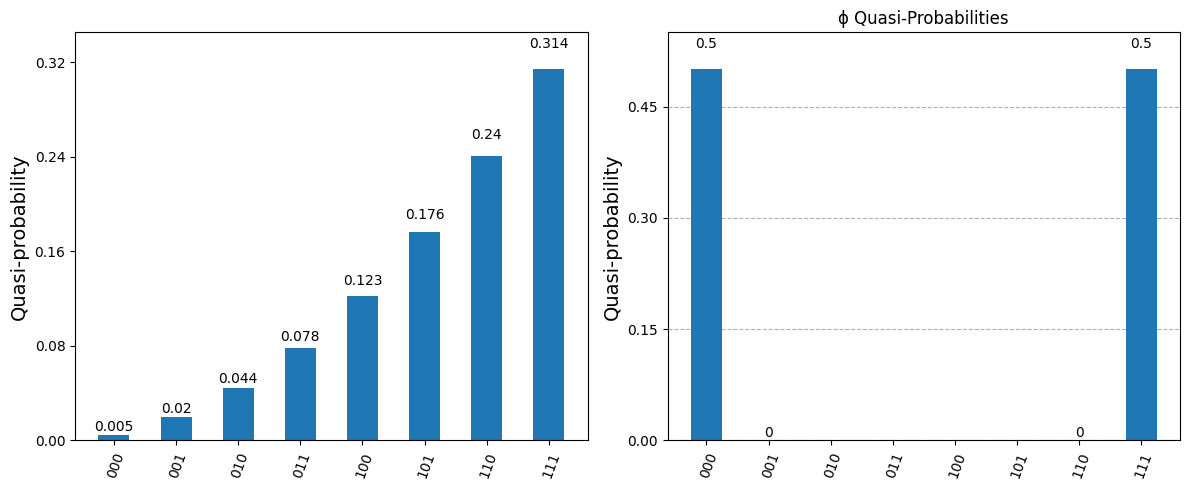

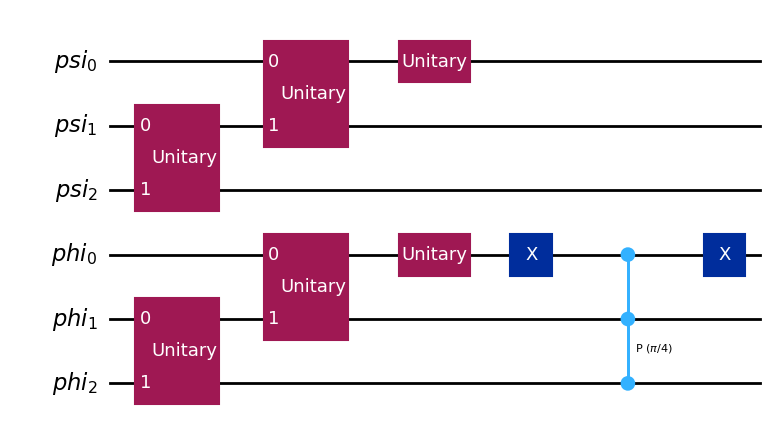

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from qiskit_aer import AerSimulator

# Two arbitrary vectors (you can choose your own)
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 0, 0, 0, 0, 0, 0, 1]

# Create QuantumState objects and MPS-style initializer circuits
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

psi_circuit = psi_state.generate_mps_initializer_circuit(number_of_layers=2)
phi_circuit = phi_state.generate_mps_initializer_circuit(number_of_layers=2)

# Create two quantum registers
n_psi = psi_circuit.num_qubits
n_phi = phi_circuit.num_qubits

psi_reg = QuantumRegister(n_psi, name="psi")
phi_reg = QuantumRegister(n_phi, name="phi")
circuit = QuantumCircuit(psi_reg, phi_reg)


phi_circuit.x(0)
phi_circuit.mcp(np.pi/4, [0, 1], 2)
phi_circuit.x(0)


# Append the circuits to the respective registers
circuit.compose(psi_circuit, qubits=psi_reg, inplace=True)
circuit.compose(phi_circuit, qubits=phi_reg, inplace=True)

simulator = AerSimulator(method='automatic')

#psi
psi_sv = psi_circuit.copy()
psi_sv.save_statevector()
psi_result = simulator.run(transpile(psi_sv, simulator)).result()
psi_statevector = psi_result.get_statevector()

print(psi_statevector)

#for phi
phi_sv = phi_circuit.copy()
phi_sv.save_statevector()
phi_result = simulator.run(transpile(phi_sv, simulator)).result()
phi_statevector = phi_result.get_statevector()

# Compare amplitudes and phase difference
print("\nStatevector comparison (ψ vs ϕ):")
for i, (amp_psi, amp_phi) in enumerate(zip(psi_statevector, phi_statevector)):
    basis = f"|{format(i, '03b')}>"
    delta_phase = np.angle(amp_phi) - np.angle(amp_psi)
    print(f"{basis}: ψ={amp_psi}, ϕ={amp_phi}, Δphase={delta_phase:.3f} rad")


psi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(psi_statevector)}

phi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(phi_statevector)}

# Plot quasi-probabilities as histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_histogram(psi_probs, ax=axs[0], title="ψ Quasi-Probabilities")
plot_histogram(phi_probs, ax=axs[1], title="ϕ Quasi-Probabilities")
plt.tight_layout()
plt.show()

# Optional: Add measurements if needed
# circuit.measure_all()

# Draw the combined circuit
circuit.draw("mpl")


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.2018443189450112
Current number of layers: 0
delta=0.785398, m=1: Fidelity=0.999584
delta=0.748195, m=1: Fidelity=0.999658
delta=0.710992, m=1: Fidelity=0.999722
delta=0.673789, m=1: Fidelity=0.999777
delta=0.636586, m=1: Fidelity=0.999823
delta=0.599383, m=1: Fidelity=0.999861
delta=0.562180, m=1: Fidelity=0.999893
delta=0.524977, m=1: Fidelity=0.018089
delta=0.487774, m=1: Fidelity=0.999939
delta=0.450571, m=1: Fidelity=0.999956
delta=0.413367, m=1: Fidelity=0.999969
delta=0.376164, m=1: Fidelity=0.999979
delta=0.338961, m=1: Fidelity=0.999986
delta=0.301758, m=1: Fidelity=0.999991
delta=0.264555, m=1: Fidelity=0.999995
delta=0.227352, m=1: Fidelity=0.999997
delta=0.190149, m=1: Fidelity=0.999999
delta=0.152946, m=1: Fidelity=0.999999
delta=0.115743, m=1: Fidelity=1.000000
delta=0.078540, m=1: Fidelity=1.000000


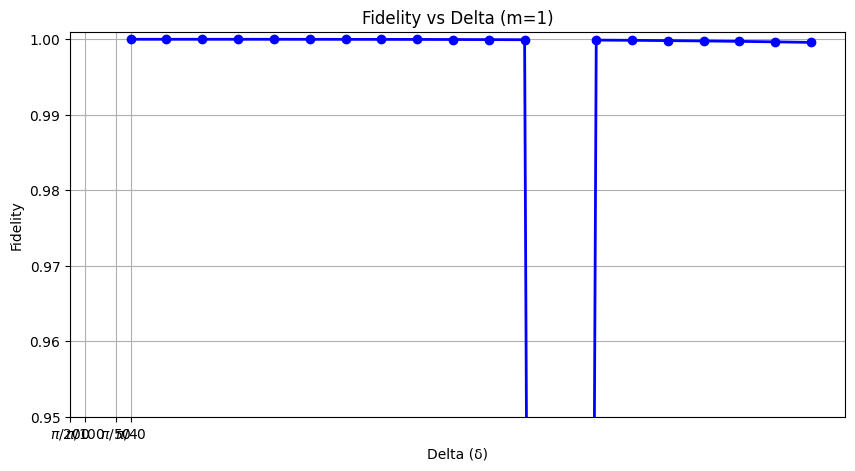

In [4]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# --- prepare states ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]
N = 8
x = np.linspace(0, 1, N, endpoint=False)   # 8 grid points
k = 3  # quantum number
phi = np.sqrt(2) * np.sin(k * np.pi * (x + 0.5/N))

n = 3  
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


def run_protocol(m, delta):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # Ideal target
    psi_vec = np.array(psi) / np.linalg.norm(psi)   # normalized ψ
    phi_vec = np.array(phi) / np.linalg.norm(phi)   # normalized φ
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    return state_fidelity(rho_psi, rho_ideal)


# --- run for delta range with fixed m ---
delta_values = np.linspace(np.pi/4, np.pi/40, 20)  # 20 points from π/4 to π/40
m = 1  # fixed iteration count
fidelities = []

for d in delta_values:
    fid = run_protocol(m, d)
    fidelities.append(fid)
    print(f"delta={d:.6f}, m={m}: Fidelity={fid:.6f}")

# --- plot results ---
plt.figure(figsize=(10,5))
plt.plot(delta_values, fidelities, 'o-', color="blue", linewidth=2, markersize=6)
plt.xlabel("Delta (δ)")
plt.ylabel("Fidelity")
plt.title(f"Fidelity vs Delta (m={m})")
plt.ylim(0.95, 1.001)
plt.grid(True)

# Optional: label some key δ values
key_deltas = [np.pi/40, np.pi/50, np.pi/100, np.pi/200]
plt.xticks(key_deltas, [r"$\pi/40$", r"$\pi/50$", r"$\pi/100$", r"$\pi/200$"])
plt.show()








Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.3638079012812616
Current number of layers: 0


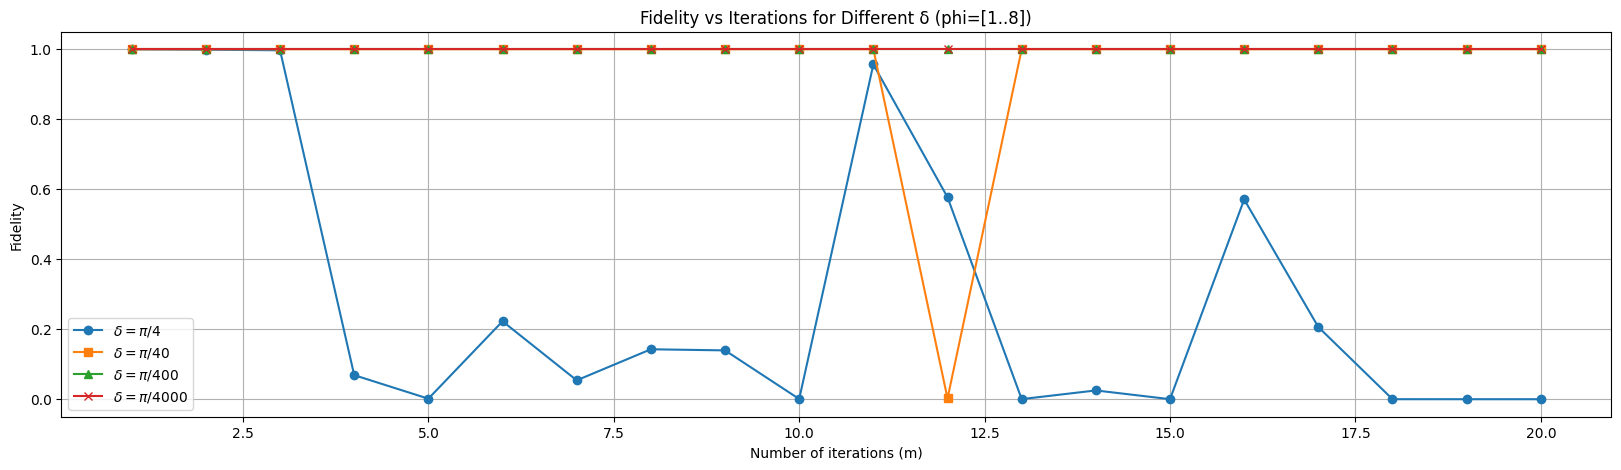

In [5]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]        # initial psi vector
phi = [1, 2, 3, 4, 5, 6, 7, 8]        # phi for programmable phase

N = 8
n = 3                    # number of qubits (log2 of vector length)
number_of_layers = 2     # layers for MPS initialization

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

# --- protocol function ---
def run_protocol(m, delta):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    # initialize states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # Ideal target vector with programmable phase
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    fid = state_fidelity(rho_psi, rho_ideal)
    return fid

# --- run for multiple iterations ---
m_values = list(range(1, 21))

#fidelity for delta = pi/4
delta0 = np.pi / 4
fidelities0 = [run_protocol(m, delta0) for m in m_values]

# fidelity for delta = pi/40
delta1 = np.pi / 40
fidelities1 = [run_protocol(m, delta1) for m in m_values]

# fidelity for delta = pi/400
delta2 = np.pi / 400
fidelities2 = [run_protocol(m, delta2) for m in m_values]

# fidelity for delta = pi/4000
delta3 = np.pi / 4000
fidelities3 = [run_protocol(m, delta3) for m in m_values]

# --- plot results ---
plt.figure(figsize=(20,5))
plt.plot(m_values, fidelities0, 'o-', label=r'$\delta = \pi/4$')
plt.plot(m_values, fidelities1, 's-', label=r'$\delta = \pi/40$')
plt.plot(m_values, fidelities2, '^-', label=r'$\delta = \pi/400$')
plt.plot(m_values, fidelities3, 'x-', label=r'$\delta = \pi/4000$')
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations for Different δ (phi=[1..8])")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
from qiskit.quantum_info import Statevector

# Pick one m to analyze (example: m=100)
m_example = 100
fid_ex, err_ex, full_state = run_protocol(m_example)

print(f"Example m={m_example}: Fidelity={fid_ex:.6f}, Error={err_ex:.6f}")

# --- Convert full_state to NumPy array ---
state_vec = full_state.data  # Access underlying array

# Simulated amplitudes and phases for first 8 states
amps_sim = np.abs(state_vec[0:8])
phases_sim = np.angle(state_vec[0:8])

# Ideal ψ amplitudes and phases (first 8 states)
psi_vec = np.array(psi) / np.linalg.norm(psi)
phi_vec = np.array(phi) / np.linalg.norm(phi)
phase_profile = np.exp(1j * delta * m_example * np.abs(phi_vec)**2)
ideal_vec = psi_vec * phase_profile

amps_ideal = np.abs(ideal_vec)
phases_ideal = np.angle(ideal_vec)

# Create basis labels
basis_labels = [format(i, f'0{n*2}b') for i in range(8)]  # first 8 states

# --- Plot phases ---
plt.figure(figsize=(15,5))
plt.bar(basis_labels, phases_sim, color='orange', alpha=0.6, label="Simulated")
plt.bar(basis_labels, phases_ideal, color='blue', alpha=0.3, label="Ideal")
plt.axhline(delta, color='red', linestyle='--', label=f"δ = {delta:.2f}")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("Basis state |ψφ>")
plt.xticks(rotation=90)
plt.title(f"Phase Comparison: Simulated vs Ideal (m={m_example})")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot amplitudes ---
plt.figure(figsize=(15,5))
plt.bar(basis_labels, amps_sim, color='orange', alpha=0.6, label="Simulated")
plt.bar(basis_labels, amps_ideal, color='blue', alpha=0.3, label="Ideal")
plt.ylabel("Amplitude magnitude")
plt.xlabel("Basis state |ψφ>")
plt.xticks(rotation=90)
plt.title(f"Amplitude Comparison: Simulated vs Ideal (m={m_example})")
plt.legend()
plt.tight_layout()
plt.show()


TypeError: run_protocol() missing 1 required positional argument: 'delta'